In [1118]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components=2, max_iter=100, tol=1e-3):
        self.n_components = n_components #number of classes K
        self.max_iter = max_iter #max number of iterations to run
        self.tol = tol #tolerance value under which to stop iterations
        
        self.weights = None #there are our pi_1, . . . , pi_K
        self.means = None #these are our vectors mu_1, . . . ,mu_K
        self.covariances = None #these are our covariance matrices Sigma_1,  . . . , Sigma_K

    def initialize_parameters(self, X):
        """This function initialize the paramters of the GMM"""
        n_samples, _ = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]
        
    def compute_logLikelihood(self, X):
        likelihoods = np.array([multivariate_normal.pdf(X, mean, cov) for mean, cov in zip(self.means, self.covariances)]).T
        weighted_likelihoods = self.weights * likelihoods
        log_likelihood = np.sum(np.log(np.sum(weighted_likelihoods, axis=1)))
        return log_likelihood

    def clean_x (self, X):
        """
        This function limits the amount of datapoints that can be zero to 10. This helps prevent overfitting.
        When running the the clustering example below, the model is fed 10% of num_samples as zeros, which can
        lead to inaccurate clusters.
        """
        num = 0
        X_cleaned = []
        for i in range (len(X)):
            if num < 10:
                X_cleaned.append(X[i])
                
            if X[i].all() == 0:
                num += 1
                        
        return np.array(X_cleaned)
        
    # E-Step
    def expectation_step(self, X):
        X = self.clean_x(X)
        likelihoods = np.array([multivariate_normal.pdf(X, mean, cov) for mean, cov in zip(self.means, self.covariances)]).T
        weighted_likelihoods = self.weights * likelihoods
        
        # Calculates the Responsibilities
        resp = np.zeros([len(X), self.n_components])
        sums = np.sum(weighted_likelihoods, axis=1)
        sums = sums[:, np.newaxis]
        responsibilities = weighted_likelihoods / sums
        
        return responsibilities

    # M-Step
    def maximization_step(self, X, responsibilities):
        X = self.clean_x(X)
        N = len(X)
        
        total_responsibilities = []
        
        # Updates the Means
        for k in range(self.n_components):            
            total_sum = np.sum(np.transpose(responsibilities)[k] * np.transpose(X), axis=1)
            N_k = np.sum(np.transpose(responsibilities)[k])
            new_mean = np.multiply((1/N_k), total_sum)
            self.means[k] = new_mean
            total_responsibilities.append(N_k)

        # Updates the Covariances
        self.covariances = []
        for k in range(self.n_components):            
            total = 0
            
            for n in range(N):
                diff = X[n] - self.means[k]          
                diff_sq = np.multiply(diff, np.transpose(diff))
                total += np.multiply(responsibilities[n][k], diff_sq) 

            N_kk = total_responsibilities[k]
            cov = np.multiply((1/N_kk), total)
            self.covariances.append(cov)


        # Updates the Weights
        self.weights = np.multiply(total_responsibilities, (1/N))


    def fit(self, X):
        self.initialize_parameters(X)
        
        for i in range(self.max_iter):
            old_log_likelihood = self.compute_logLikelihood(X)

            responsibilities = self.expectation_step(X) #Expectation Step
            self.maximization_step(X, responsibilities) #Maximization Step
            
            new_log_likelihood = self.compute_logLikelihood(X)
            
            # Check for convergence of the log_likelihood
            if np.abs(old_log_likelihood - new_log_likelihood) < self.tol:
                break

    def predict(self, X):
        likelihoods = np.array([multivariate_normal.pdf(X, mean, cov) for mean, cov in zip(self.means, self.covariances)]).T
        return np.argmax(likelihoods, axis=1)

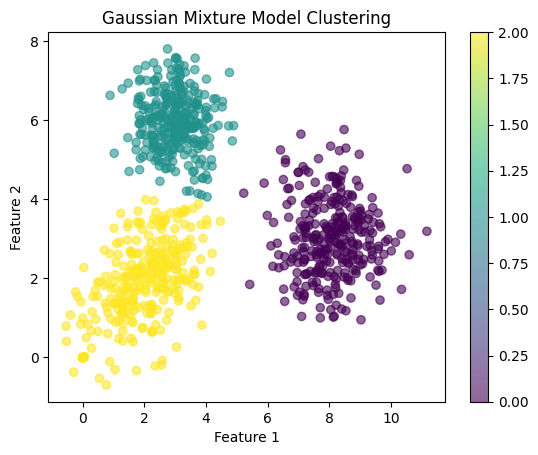

In [1119]:
### DO NOT CHANGE THIS PART

np.random.seed(0)
num_samples = 1000
num_features = 2
num_components = 3
means = np.array([[2, 2], [8, 3], [3, 6]])
covariances = np.array([[[1, 0.5], [0.5, 1]], [[1, 0], [0, 1]], [[0.5, 0], [0, 0.5]]])
weights = np.array([0.4, 0.3, 0.3])

X = np.zeros((num_samples, num_features))
for i in range(num_components):
    num_samples_i = int(weights[i] * num_samples)
    X[i * num_samples_i: (i + 1) * num_samples_i] = np.random.multivariate_normal(means[i], covariances[i], num_samples_i)

# Fit Gaussian Mixture Model
gmm = GaussianMixtureModel(n_components=num_components)
gmm.fit(X)

# Predict cluster probabilities 
predicted_lab = gmm.predict(X)

import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=predicted_lab, cmap='viridis', alpha=0.6)


plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Model Clustering')
plt.colorbar()
plt.show()